# Scanpy: Trajectory inference for hematopoiesis in mouse
元URL: https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html

（更新日:2020-12-28）

Scanpyを用いた軌道解析です。軌道解析法には partition-based graph abstraction (PAGA; Wolf et al, 2019) を採用しています。PAGAは細胞数が多く軌道が複雑であるようなサンプルに対して有効であるとされています。

In [ ]:
# Google Colabで実行する場合は まずScanpyインストール
#!pip install seaborn scikit-learn statsmodels numba python-igraph louvain scanpy

In [1]:
# ライブラリ読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
results_file = './write/paul15.h5ad'
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(4, 4), facecolor='white')  # low dpi (dots per inch) yields small inline figures

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.2 scipy==1.5.2 pandas==1.1.5 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.8.3


## データ読み込み
ここではscanpyライブラリ内で提供されている paul15 データ (Hematopoiesis from self-renewing stem cells) を用います。 細胞アノテーションつきの 2,730 細胞データです。

In [2]:
adata = sc.datasets.paul15()
adata

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.


AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters'
    uns: 'iroot'

In [3]:
# Optional: 計算精度向上のために 型をfloat32からfloat64に変更
# this is not required and results will be comparable without it
adata.X = adata.X.astype('float64')

## 正規化、次元削減、クラスタリング


In [4]:
# 正規化、HVGの抽出
sc.pp.recipe_zheng17(adata)

running recipe zheng17
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
    finished (0:00:00)


In [5]:
# PCAの計算
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:00)


In [6]:
# 第20主成分までを用いてグラフクラスタリング
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:50)


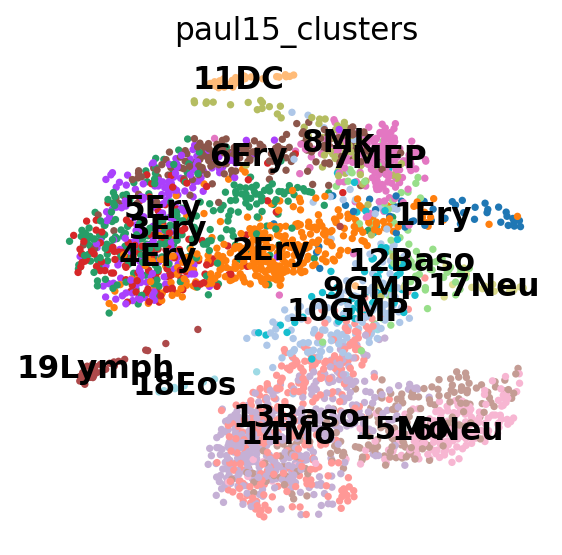

In [7]:
# 可視化
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

ここではまだ結果がmessy（ばらつきが大きい）ように見えます。

## Optional: Denoising the graph

グラフからノイズ除去するには，PCA空間上ではなくdiffusion map で表現します。
いくつかの拡散成分 (diffusion components)上で距離を計算することがグラフのノイズ除去に相当します。
これはPCAを用いたデータ行列のノイズ除去に非常に似ています。
これは[MAGIC](https://doi.org/10.1016/j.cell.2018.05.061)の背後にある原理にも関連しています。

In [8]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.9989278  0.99671    0.99430376 0.98939794
     0.9883687  0.98731077 0.98398703 0.983007   0.9790806  0.9762548
     0.9744365  0.9729161  0.9652972 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [9]:
sc.tl.draw_graph(adata)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:50)


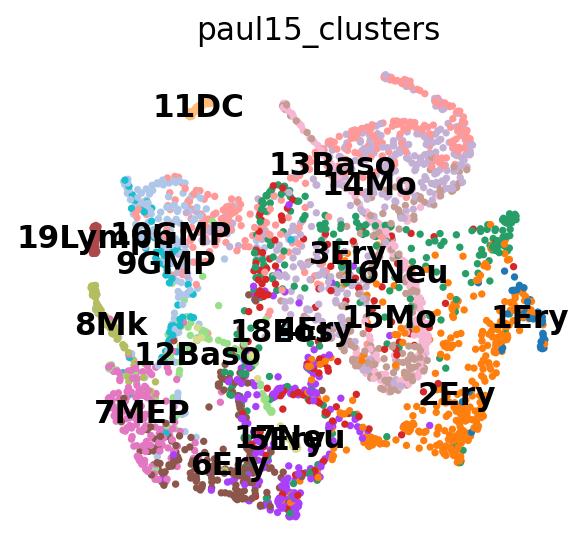

In [10]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

This still looks messy, but in a different way: a lot of the branches are overplotted.

## PAGAの実行
PAGAは得られたクラスタを一つのノードとみなし、ノードごとの関係性を可視化することにより、大規模かつ複雑なグラフの「粗視化」ネットワークを推定します。

注：ここでは再現性のためクラスタリングには`sc.tl.louvain`を使っていますが、最新版では`sc.tl.leiden`を採用しています。

In [12]:
# クラスタリング
sc.tl.louvain(adata, resolution=1.0)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 25 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


単純な粗視化された可視化のために、粗視化され抽象化され）グラフであるPAGAグラフを計算します。
粗視化されたグラフの中の重要でないエッジは，閾値で除去されます．

In [13]:
# PAGA実行
sc.tl.paga(adata, groups='louvain')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


## クラスタのアノテーション
以下の既知のマーカを元に各クラスタをアノテートします。

|cell type|	marker|
|---|---|
|HSCs|	Procr|
|Erythroids|	Gata1, Klf1, Epor, Gypa, Hba-a2, Hba-a1, Spi1|
|Neutrophils|	Elane, Cebpe, Ctsg, Mpo, Gfi1|
|Monocytes|	Irf8, Csf1r, Ctsg, Mpo|
|Megakaryocytes|	Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf|
|Basophils|	Mcpt8, Prss34|
|B cells|	Cd19, Vpreb2, Cd79a|
|Mast cells|	Cma1, Gzmb, CD117/C-Kit|
|Mast cells & Basophils	|Ms4a2, Fcer1a, Cpa3, CD203c (human)|

--> added 'pos', the PAGA positions (adata.uns['paga'])


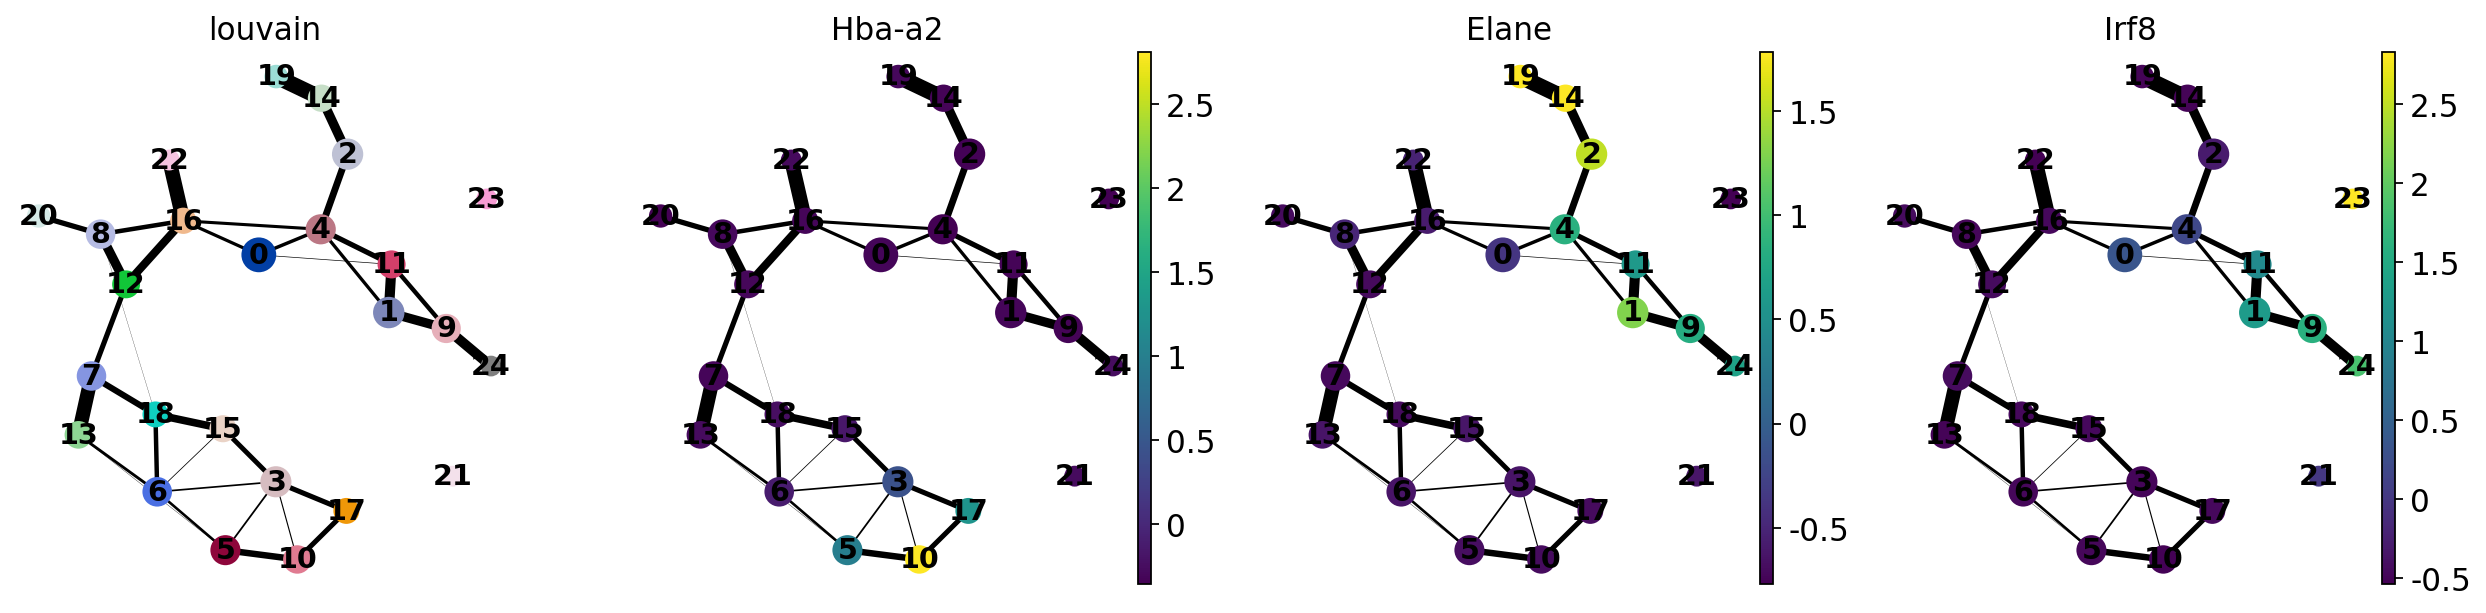

In [14]:
sc.pl.paga(adata, color=['louvain', 'Hba-a2', 'Elane', 'Irf8'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


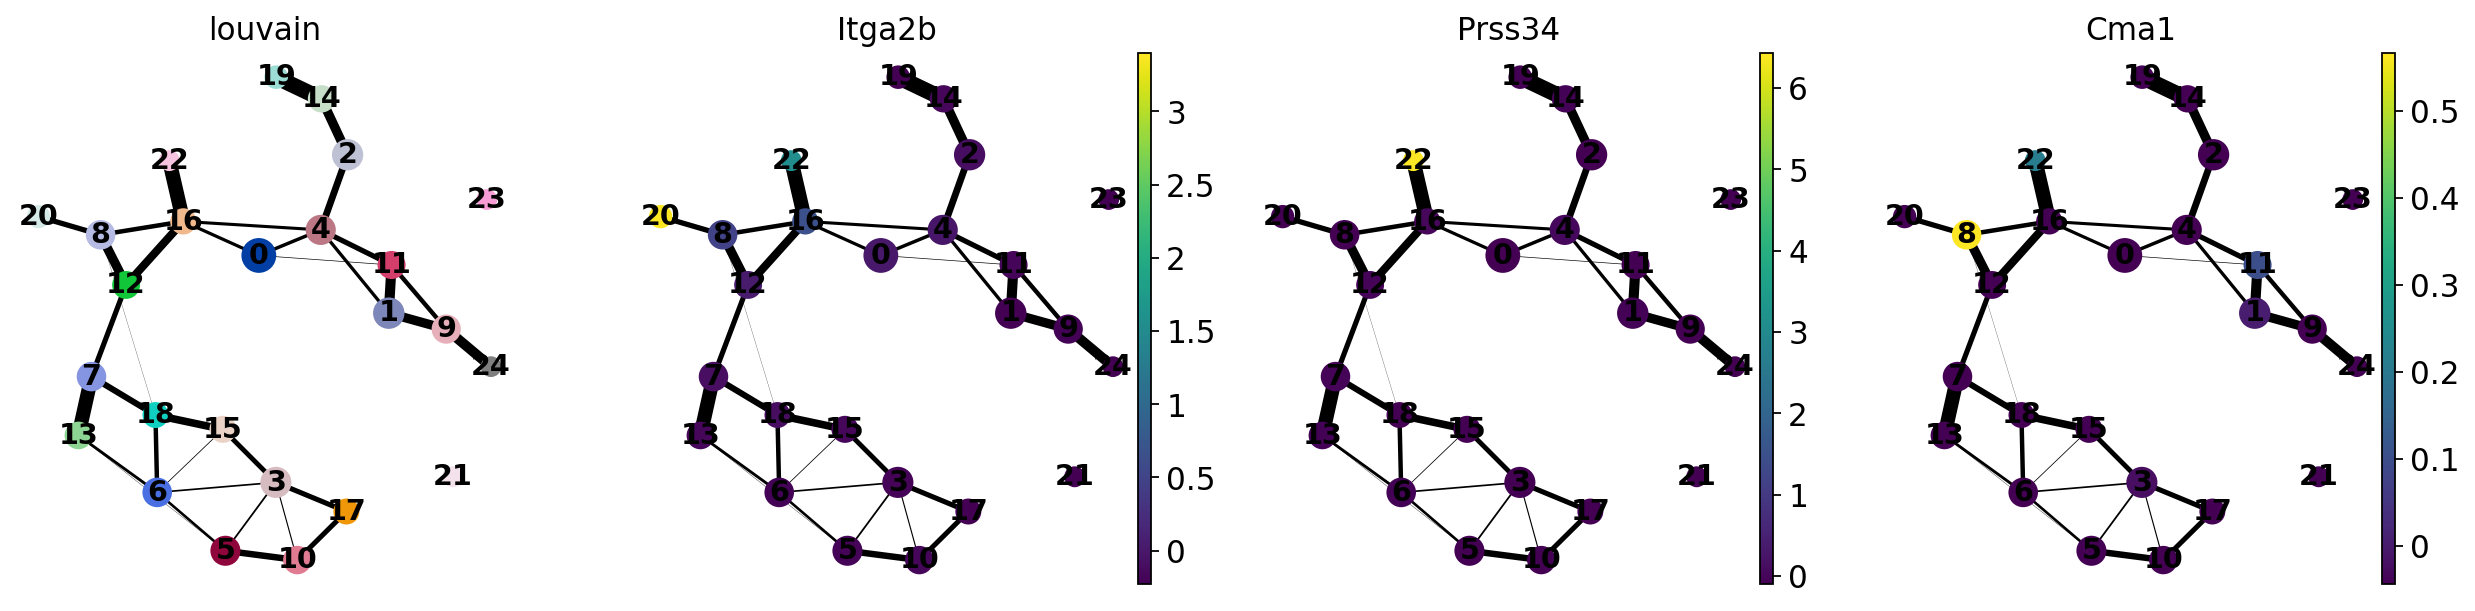

In [15]:
sc.pl.paga(adata, color=['louvain', 'Itga2b', 'Prss34', 'Cma1'])

マーカー遺伝子の発現を見て、実際にクラスタをアノテーションします。
`Cma1`はMast細胞マーカーであり、前駆細胞/幹細胞クラスタ(8)のごく一部の細胞にしか現れないことに注意してください、

In [17]:
adata.obs['louvain'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'],
      dtype='object')

In [18]:
# アノテーションをもとにクラスタのラベルを修正
adata.obs['louvain_anno'] = adata.obs['louvain']
adata.obs['louvain_anno'].cat.categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10/Ery', '11', '12',
       '13', '14', '15', '16/Stem', '17', '18', '19/Neu', '20/Mk', '21', '22/Baso', '23', '24/Mo']

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


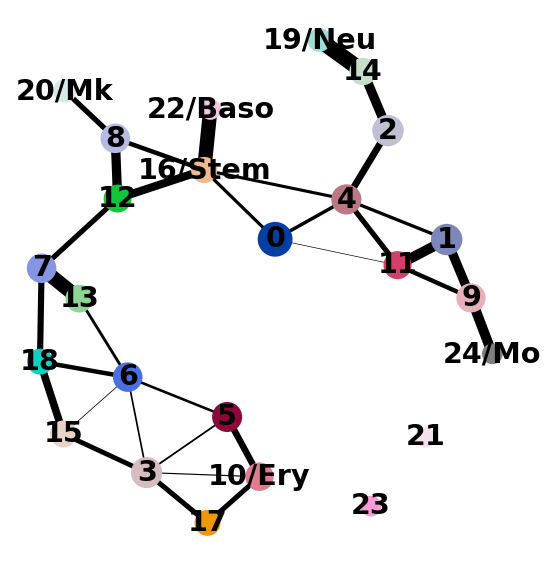

In [20]:
sc.tl.paga(adata, groups='louvain_anno')
sc.pl.paga(adata, threshold=0.03, show=False)

## 細胞レベルでの2次元プロット
PAGAで得られたクラスタレベルのネットワーク情報をもとに、細胞レベルでの2次元マップを再構築します。

In [21]:
sc.tl.draw_graph(adata, init_pos='paga')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:50)


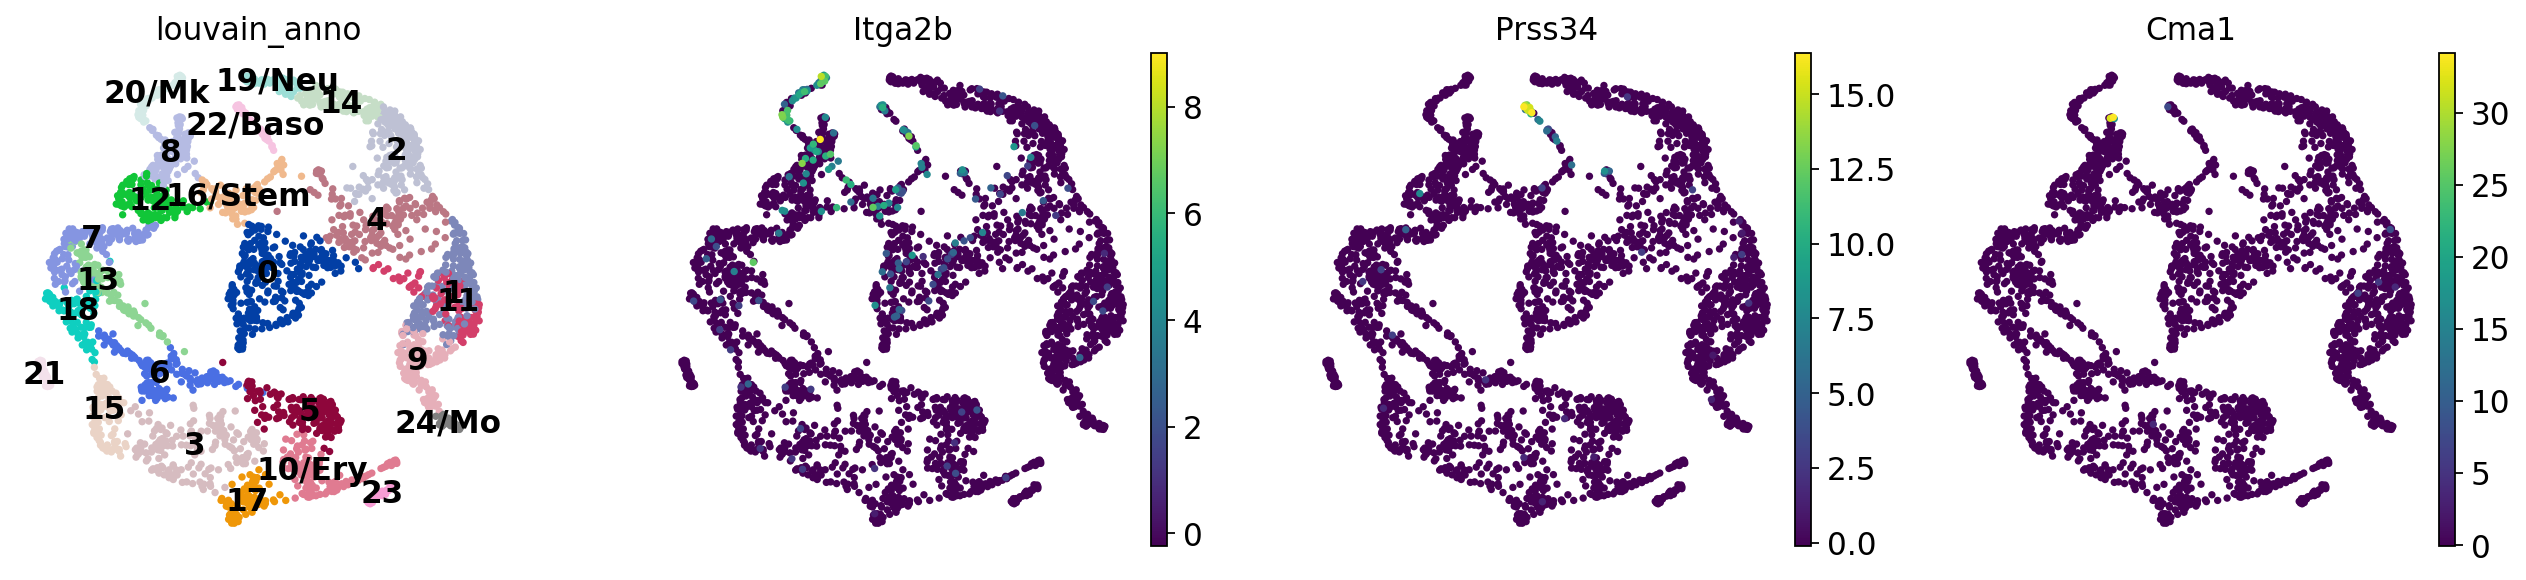

In [22]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'Itga2b', 'Prss34', 'Cma1'], legend_loc='on data')

### 色の変更
色が見づらいのでもう少し綺麗なカラーマップに変更します。

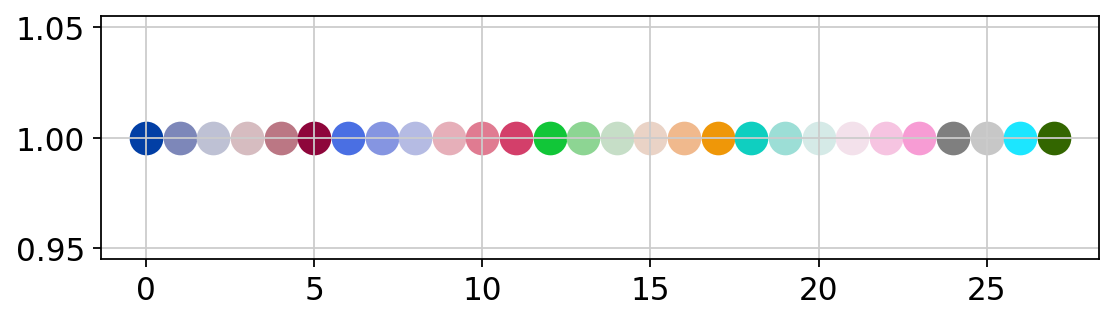

In [24]:
pl.figure(figsize=(8, 2))
for i in range(28):
    pl.scatter(i, 1, c=sc.pl.palettes.zeileis_28[i], s=200)
pl.show()

In [25]:
zeileis_colors = np.array(sc.pl.palettes.zeileis_28)
new_colors = np.array(adata.uns['louvain_anno_colors'])

In [26]:
new_colors[[16]] = zeileis_colors[[12]]  # Stem colors / green
new_colors[[10, 17, 5, 3, 15, 6, 18, 13, 7, 12]] = zeileis_colors[[5, 5, 5, 5, 11, 11, 10, 9, 21, 21]]  # Ery colors / red
new_colors[[20, 8]] = zeileis_colors[[17, 16]]  # Mk early Ery colors / yellow
new_colors[[4, 0]] = zeileis_colors[[2, 8]]  # lymph progenitors / grey
new_colors[[22]] = zeileis_colors[[18]]  # Baso / turquoise
new_colors[[19, 14, 2]] = zeileis_colors[[6, 6, 6]]  # Neu / light blue
new_colors[[24, 9, 1, 11]] = zeileis_colors[[0, 0, 0, 0]]  # Mo / dark blue
new_colors[[21, 23]] = zeileis_colors[[25, 25]]  # outliers / grey

In [28]:
adata.uns['louvain_anno_colors'] = new_colors

また、いくつかのクラスタ名には空白を追加してください。ここに示されているレイアウトは元論文とは異なりますが、これらの違いはcosmeticなものにすぎません。ランダム化PCAとfloat32からfloat64の精度に移行したため、レイアウトを変更しなければなりませんでした。

--> added 'pos', the PAGA positions (adata.uns['paga'])


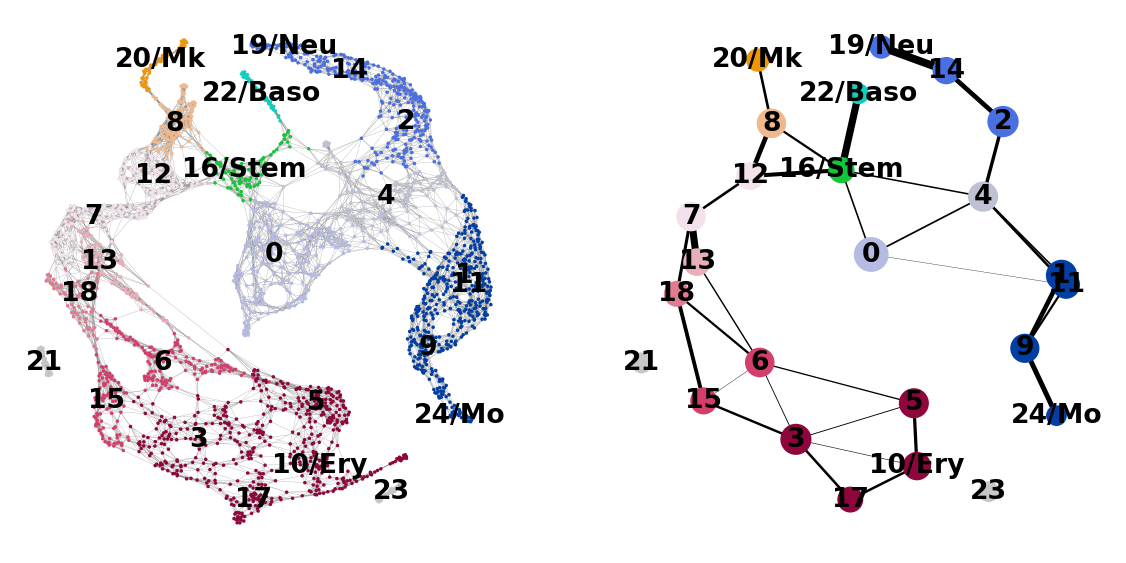

In [31]:
# 細胞レベルとクラスタレベルでの可視化
sc.pl.paga_compare(
    adata, threshold=0.03, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True, save=True)

## Reconstructing gene changes along PAGA paths for a given set of genes

PAGAの軌道に沿った遺伝子発現の変化を可視化

In [30]:
# どのクラスタをrootにするかを選ぶ。ここでは16/Stemを選択
adata.uns['iroot'] = np.flatnonzero(adata.obs['louvain_anno']  == '16/Stem')[0]

In [32]:
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


In [33]:
# 軌道解析のためのマーカ遺伝子を指定
gene_names = ['Gata2', 'Gata1', 'Klf1', 'Epor', 'Hba-a2',  # erythroid
              'Elane', 'Cebpe', 'Gfi1',                    # neutrophil
              'Irf8', 'Csf1r', 'Ctsg']                     # monocyte

In [39]:
# データを生成しなおし（adata.raw に格納）
adata_raw = sc.datasets.paul15()
sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
adata.raw = adata_raw

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.


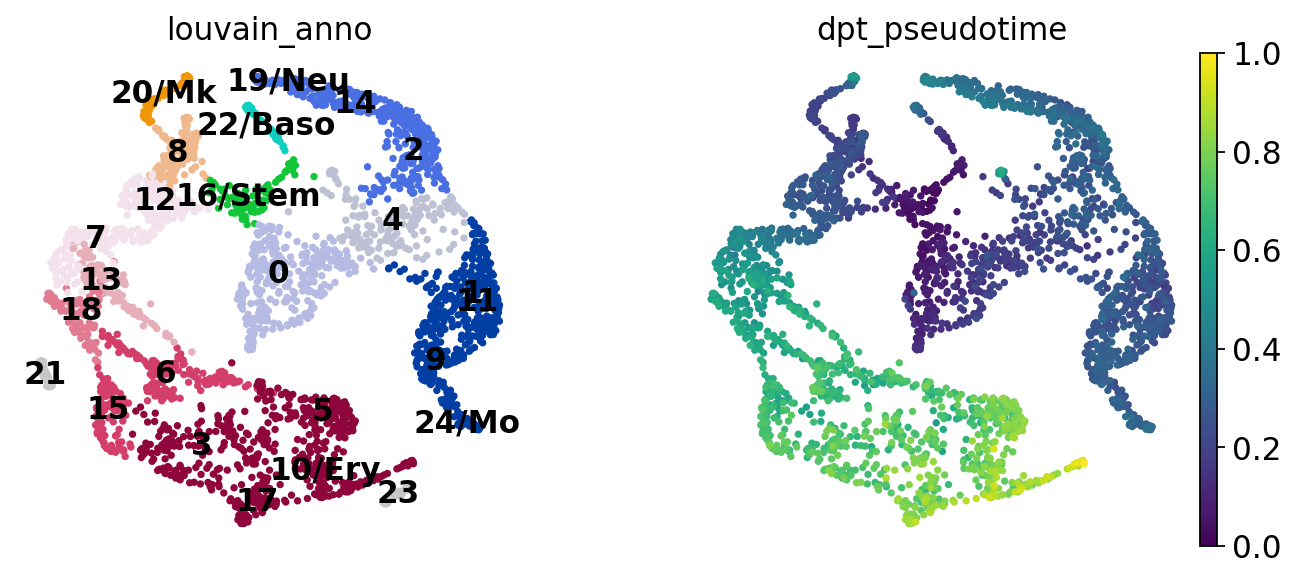

In [40]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'dpt_pseudotime'], legend_loc='on data')

In [41]:
# パスの定義
paths = [('erythrocytes', [16, 12, 7, 13, 18, 6, 5, 10]),
         ('neutrophils', [16, 0, 4, 2, 14, 19]),
         ('monocytes', [16, 0, 4, 11, 1, 9, 24])]

In [42]:
adata.obs['distance'] = adata.obs['dpt_pseudotime']
adata.obs['clusters'] = adata.obs['louvain_anno']  # just a cosmetic change
adata.uns['clusters_colors'] = adata.uns['louvain_anno_colors']

In [43]:
!mkdir -p write

遺伝子の可視化


/opt/conda/lib/python3.7/site-packages/scanpy/plotting/_tools/paga.py:1177: UserWarning: FixedFormatter should only be used together with FixedLocator
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/opt/conda/lib/python3.7/site-packages/scanpy/plotting/_tools/paga.py:1220: UserWarning: FixedFormatter should only be used together with FixedLocator
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)


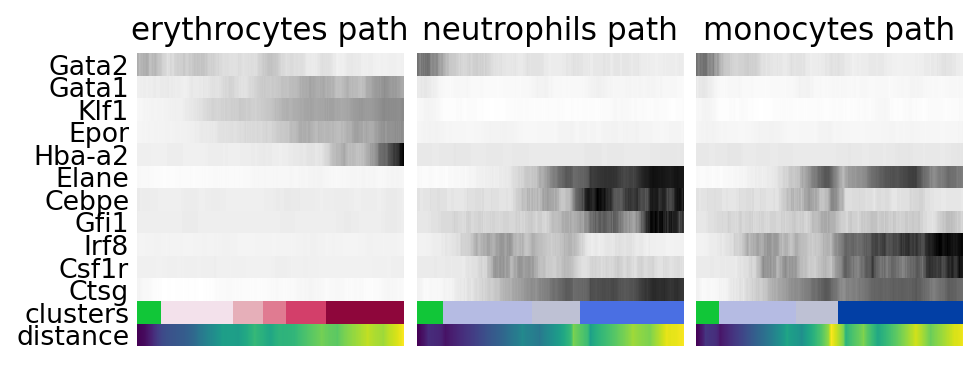

In [44]:
_, axs = pl.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='clusters',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
    data.to_csv('./write/paga_path_{}.csv'.format(descr))
pl.savefig('./figures/paga_path_paul15.pdf')
pl.show()

In [45]:
from sinfo import sinfo
sinfo()

-----
anndata     0.7.5
matplotlib  3.3.3
numpy       1.19.2
pandas      1.1.5
scanpy      1.6.0
sinfo       0.3.1
-----
IPython             7.13.0
jupyter_client      6.1.7
jupyter_core        4.7.0
jupyterlab          2.2.9
notebook            6.1.5
-----
Python 3.7.7 (default, Mar 23 2020, 22:36:06) [GCC 7.3.0]
Linux-5.4.0-47-generic-x86_64-with-debian-buster-sid
72 logical CPU cores, x86_64
-----
Session information updated at 2020-12-29 16:36
